# Mitigating batch effects between HBN and HNU1 datasets using linear regression and random forest regression
Vivek Gopalakrishnan | February 19, 2019

## Overview:
In this notebook, I implement two regression methods to mitigate batch effects. 

## Contents
1. Import data and embed
2. Use linear regression and random forest regression on omni

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import graspy as gs
from graspy.utils import import_graph

from collections import OrderedDict
import os

### 1. Import data and embed

**PROCEDURE:**
1. Import the data
2. Transform using `cMDS o omni o PTR`
3. Visualize via pair plot for sanity

In [2]:
hbn = []
hnu = []

# Load HBN
for root, dirs, files in os.walk('../../data/HBN'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_weighted_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hbn.append(G)
            
# Load HNU1
for root, dirs, files in os.walk('../../data/HNU1'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hnu.append(G)

# Convert to numpy array
hbn = np.array(hbn)
hnu = np.array(hnu)
print("Number of patients in HBN: {}".format(len(hbn)))
print("Number of patients in HNU1: {}".format(len(hnu)))

Number of patients in HBN: 99
Number of patients in HNU1: 300


In [3]:
def embed(data, n_components=50, n_population=75):
    """Embed a subset of an array of connectomes (data) in specified number of dimensions."""
    
    omni = gs.embed.OmnibusEmbed(n_components=n_components)
    Zhat = omni.fit_transform(
        data[np.random.choice(len(data), size=n_population)]
    )
    
    return Zhat

In [4]:
# Constants
n_components = 50
n_population = 50

# Embed the data
Zhat_hbn = embed(hbn, n_population=n_population)
Zhat_hnu = embed(hnu, n_population=n_population)

# Verify embedding shapes for sanity
print(Zhat_hbn.shape)
print(Zhat_hnu.shape)

(3500, 50)
(3500, 50)


In [5]:
# Combine embeddings
Zhat = np.vstack([Zhat_hbn, Zhat_hnu])
print(Zhat.shape)

# Tensor: subject x node x Euclidean representation
Zhat = Zhat.reshape((n_population * 2, 70, -1))
print(Zhat.shape)

# Dim reduce: subject x components
cmds = gs.embed.ClassicalMDS(n_components=20)
Xhat = cmds.fit_transform(Zhat)
print(Xhat.shape)

(7000, 50)
(100, 70, 50)
(100, 20)


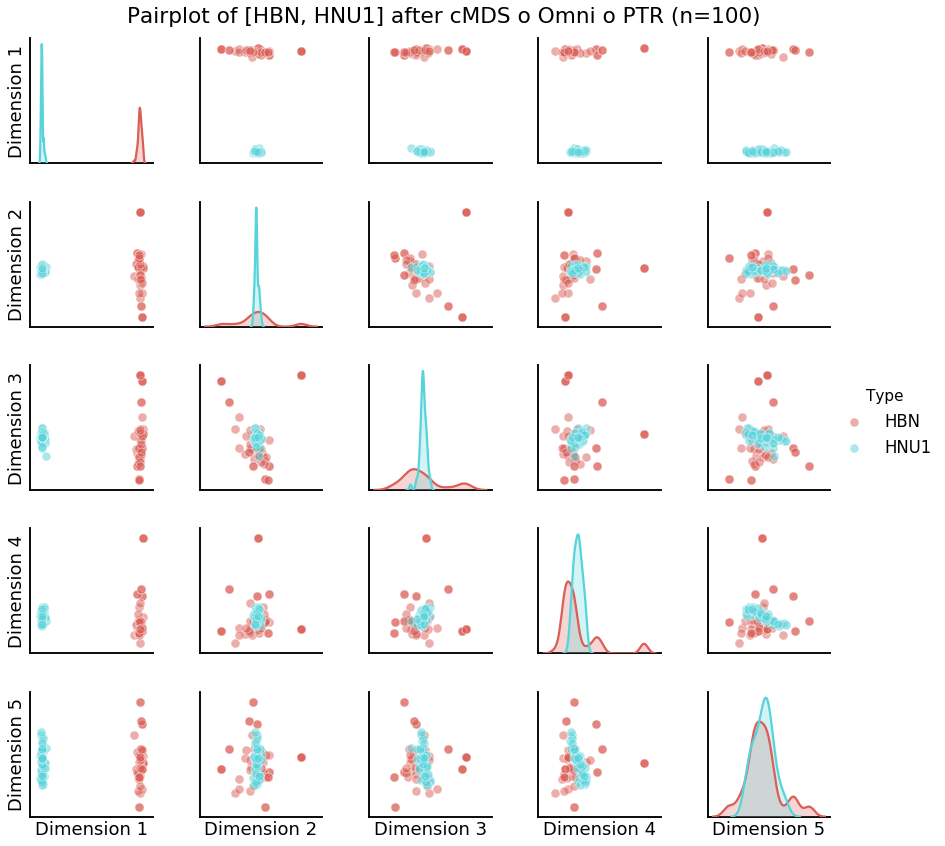

In [6]:
# Labels for dimensions
variables = ['Dimension {}'.format(i) for i in range(1, Xhat.shape[1] + 1)]
labels = ['HBN']*n_population + ['HNU1']*n_population

# Pair plot of first 5 components of CMDS
gs.plot.pairplot(
    Xhat, 
    alpha=0.5,
    Y=labels, 
    palette='hls', 
    col_names=variables, 
    variables=variables[:5], 
    title='Pairplot of [HBN, HNU1] after cMDS o Omni o PTR (n={})'.format(n_population*2)
)

plt.show()

### 2. Try the regression methods

**METHODS:**
1. Linear regression
2. Random forest regression

Apply these methods to the embeddings generated above.

In [7]:
# Quantify seperation
def calculate_distance(regressed_embedding, n_population):
    pop1 = regressed_embedding[:n_population,:]
    pop2 = regressed_embedding[n_population:,:]
    
    return np.abs(np.mean(pop1-pop2, dtype=np.float64))

In [8]:
batch = np.array([-1]*n_population + [1]*n_population)

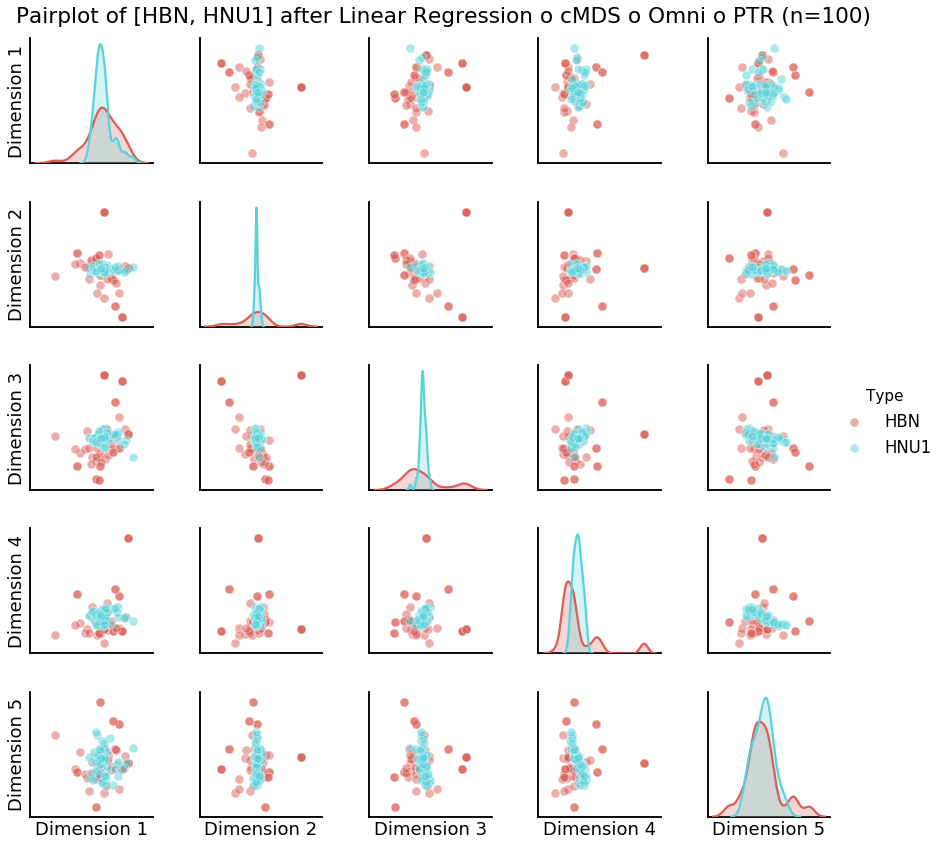

1.2789769243681802e-16


In [9]:
# Linear regression
from sklearn.linear_model import LinearRegression

# Regress out the batch
re_batch = batch.reshape(-1, 1)
lr = LinearRegression()
lr.fit(re_batch, Xhat)
X_lr_regressed = Xhat - lr.predict(re_batch)

# Pair plot of first 5 components of CMDS
gs.plot.pairplot(
    X_lr_regressed,
    alpha=0.5,
    Y=labels, 
    palette='hls', 
    col_names=variables, 
    variables=variables[:5], 
    title='Pairplot of [HBN, HNU1] after Linear Regression o cMDS o Omni o PTR (n={})'.format(n_population*2),
)

plt.show()

print(calculate_distance(X_lr_regressed, n_population))

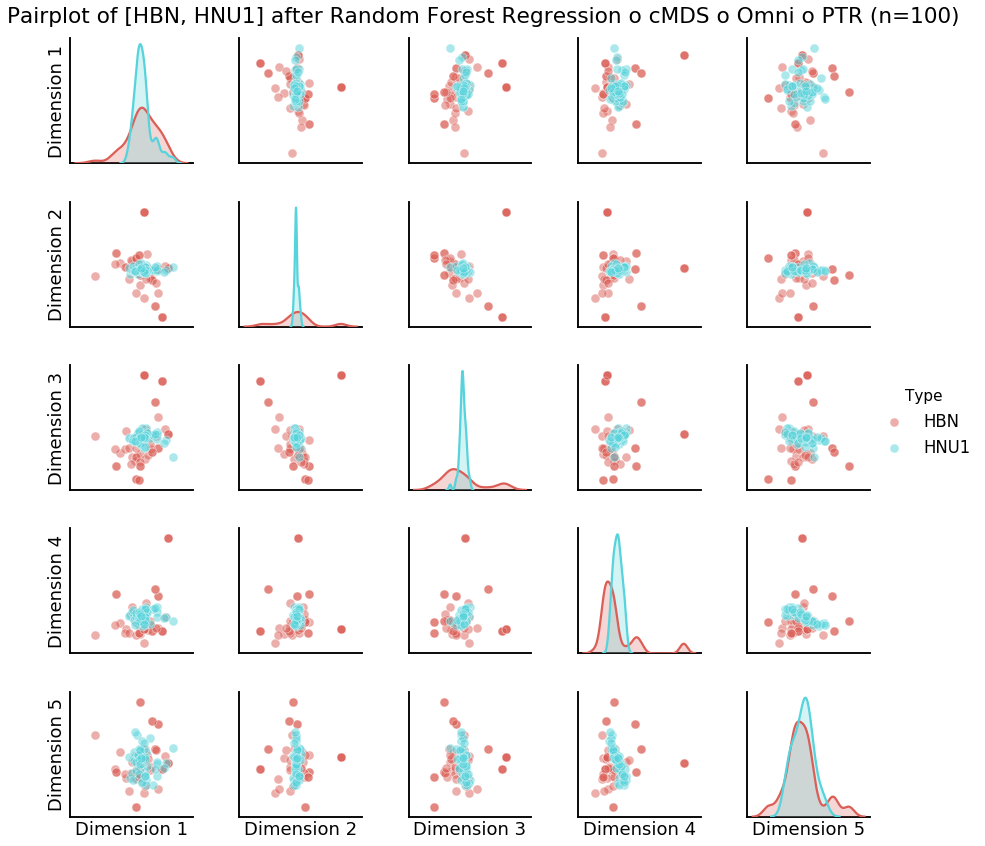

0.002218935865528341


In [10]:
# Random forest regression
from sklearn.ensemble import RandomForestRegressor

# Regress out the batch
re_batch = batch.reshape(-1, 1)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(re_batch, Xhat)
X_rf_regressed = Xhat - rf.predict(re_batch)

# Pair plot of first 5 components of CMDS
gs.plot.pairplot(
    X_rf_regressed,
    alpha=0.5,
    Y=labels, 
    palette='hls', 
    col_names=variables, 
    variables=variables[:5], 
    title='Pairplot of [HBN, HNU1] after Random Forest Regression o cMDS o Omni o PTR (n={})'.format(n_population*2),
)

plt.show()

print(calculate_distance(X_rf_regressed, n_population))

In [11]:
# Linear regression and random forest regression are not producing the same output=
X_lr_regressed == X_rf_regressed

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [12]:
# Quantify the degree difference
from numpy import linalg as la
la.norm(X_lr_regressed - X_rf_regressed, 'fro')

0.16727326629905104